# Control of Microbial Dynamics with Neural ODEs

This notebook demonstrates how neural ordinary differential equations (ODEs) can be used to model and control microbial populations, with a focus on treating *C. difficile* infections while minimizing antibiotic use.

The relevant method papers are:

- Asikis, T., Böttcher, L. and Antulov-Fantulin, N., 2022. [Neural ordinary differential equation control of dynamics on graphs](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.013221). Physical Review Research, 4(1), p.013221.

- Böttcher, L., Antulov-Fantulin, N. and Asikis, T., 2022. [AI Pontryagin or how artificial neural networks learn to control dynamical systems](https://www.nature.com/articles/s41467-021-27590-0). Nature Communications, 13(1), p.333.

- Böttcher, L. and Asikis, T., 2022. [Near-optimal control of dynamical systems with neural ordinary differential equations](https://iopscience.iop.org/article/10.1088/2632-2153/ac92c3/meta). Machine Learning: Science and Technology, 3(4), p.045004.

## Key Concepts
- Simulation of microbial ecosystems using generalized Lotka-Volterra (gLV) equations
- Neural network-based antibiotic dosing controller
- Targeted treatment optimization
- Visualization of microbial population dynamics

## Mathematical Background

We consider the generalized Lotka--Volterra (gLV) model with control:

$$
\frac{dx_i}{dt} = x_i \left( b_i + \sum_j M_{ij} x_j + \epsilon_i u(t) \right)
$$

- $x_i(t)$: abundance of species $i$
- $b_i$: intrinsic growth rate
- $M_{ij}$: interaction-matrix element
- $\epsilon_i$: antibiotic susceptibility
- $u(t)$: control input (antibiotic dose)

Our control objective is to suppress *C. difficile* while reducing total antibiotic usage.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from copy import deepcopy
import matplotlib.pyplot as plt

## Microbial Species

We model 11 microbial species with their abbreviations:

In [2]:
species = [
    'Barnesiella',         # Bar
    'und. Lachnospiraceae', # uLac
    'uncl. Lachnospiraceae', # ucLac
    'Other',               # Oth
    'Blautia',             # Blau
    'und. Mollicutes',     # uMol
    'Akkermansia',         # Akk
    'Coprobacillus',       # Cop
    'C. difficile',        # Cdif
    'Enterococcus',        # Ent
    'und. Enterobacteriaceae' # uEnt
]

Initial conditions and parameters are based on experimental data.

- Stein, R.R., Bucci, V., Toussaint, N.C., Buffie, C.G., Rätsch, G., Pamer, E.G., Sander, C. and Xavier, J.B., 2013. [Ecological modeling from time-series inference: insight into dynamics and stability of intestinal microbiota](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003388). PLoS Computational Biology, 9(12), p.e1003388.
  
- Jones, E.W. and Carlson, J.M., 2018. [In silico analysis of antibiotic-induced Clostridium difficile infection: Remediation techniques and biological adaptations](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006001). PLoS Computational Biology, 14(2), p.e1006001.

In [3]:
# Initial condition
IC5 = torch.tensor([
    2.7665, 3.0209, 0.5964, 1.931, 0.0097317, \
    0.0083412, 0.0, 0.0097317, 1e-10, 0.0, 0.001155
], dtype=torch.float32)

# Growth rates
growth_rates = torch.tensor([
    0.36807, 0.31023, 0.35610, 0.54006, 0.70898,
    0.47064, 0.22970, 0.83005, 0.39181, 0.29075, 0.32367
], dtype=torch.float32)

# Interaction matrix (11x11)
interaction_matrix = torch.tensor([
    [-0.20516, 0.098398, 0.16739, -0.16461, -0.14341, 0.019881, -0.51535, -0.39162, 0.34635, 0.0088853, -0.26894],
    [0.062123, -0.10489, -0.043011, -0.15466, -0.1872, 0.027031, -0.45919, -0.41388, 0.3013, 0.022081, -0.19657],
    [0.14373, -0.19203, -0.10162, -0.13971, -0.16537, 0.013651, -0.50414, -0.7724, 0.29257, -0.005959, -0.20645],
    [0.22403, 0.13813, 0.00045883, -0.83125, -0.2238, 0.22027, -0.20529, -1.0097, 0.66639, -0.038986, -0.40032],
    [-0.18016, -0.051261, -5.03e-05, -0.054212, -0.70858, 0.016198, -0.50756, 0.55363, 0.15757, 0.22438, 0.10635],
    [-0.11159, -0.03721, -0.042591, 0.041044, 0.26134, -0.42266, -0.18536, -0.43231, 0.1647, -0.061038, -0.26461],
    [-0.12669, -0.18576, -0.12222, 0.3809, 0.4003, -0.16078, -1.2124, 1.3897, -0.37922, 0.19189, -0.096352],
    [-0.071257, 0.00060448, 0.080355, -0.4548, -0.50349, 0.16899, -0.56222, -4.3508, 0.44315, -0.22341, -0.2074],
    [-0.037541, -0.033333, -0.049912, -0.090424, -0.10211, 0.03229, -0.18179, -0.30301, -0.055765, 0.01436, -0.0076697],
    [-0.04225, -0.013105, 0.02398, -0.11784, -0.32893, 0.020748, 0.054767, -2.0963, 0.11124, -0.19213, 0.023816],
    [-0.3742, 0.27843, 0.24887, -0.16829, 0.08399, 0.033691, -0.23242, -0.39513, 0.31454, -0.038764, -0.3841]
], dtype=torch.float32)

# Antibiotic susceptibilities
susceptibilities = torch.tensor([
    -3.2926, -3.0354, -2.0909, -1.9395, -1.3491,
    -1.1018, -0.92446, -0.79401, -0.31272, 1.0671, 3.7009
], dtype=torch.float32)

# Targeted susceptibilities (only affects C. difficile)
targeted_susceptibilities = torch.tensor([
    0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, -1.0, 0.0, 0.0
], dtype=torch.float32)

## Model Architecture

### Antibiotic Dosing Controller
A neural network that outputs antibiotic dose based on time:

In [4]:
class AntibioticNN(nn.Module):
    def __init__(self, num_layers=5, hidden_dim=4):
        super().__init__()
        layers = []
        input_dim = 1
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ELU())
            input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.ReLU())  # ensure positive output
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

### gLV Dynamics with Control
Modified gLV equations incorporating the neural controller:

In [5]:
class gLV(nn.Module):
    def __init__(self, b, M, eps, u_net, targeted_antibiotic=False, eps_tilde=None):
        super().__init__()
        self.b = b
        self.M = M
        self.eps = eps
        self.targeted_antibiotic = targeted_antibiotic
        self.eps_tilde = eps_tilde
        self.u_net = u_net

    def forward(self, t, x):
        u = self.u_net(t.unsqueeze(0)).squeeze()
        interaction = torch.matmul(self.M, x)
        if t <= 1:  # Initial dosage regimen
            dxdt = x * (self.b + interaction + 1 * self.eps)
        elif self.targeted_antibiotic & ((t >= 100) & (t <= 110)):  # Treatment with targeted antibiotic
            dxdt = x * (self.b + interaction + self.eps_tilde * u)
        else:  # Normal dynamics
            dxdt = x * (self.b + interaction)
        return dxdt

In [6]:
# Initialize models
torch.manual_seed(42)
u_net = AntibioticNN()
model = gLV(growth_rates, interaction_matrix, susceptibilities, u_net)

# Time domain (150 days)
t = torch.linspace(0, 150, 500)

# Solve ODE
trajectory = odeint(model, IC5, t, method='dopri5')
trajectory_baseline = trajectory  # Save baseline for comparison

## Optimization

We optimize the controller to:
1. Minimize *C. difficile* abundance during and after treatment (days 100-150)
2. Minimize antibiotic usage (regularization term)

Loss function:

In [7]:
def loss_fn(trajectory, u_net, t):
    cdiff = trajectory[:, 8][t >= 100]  # C. difficile is index 8
    
    # Only consider treatment window for regularization
    mask = (t >= 100) & (t <= 110)
    t_sub = t[mask]
    
    # L2 regularization on control signal
    reg = 0.01 * torch.mean(u_net(t_sub.unsqueeze(-1)) ** 2)
    
    loss = cdiff.mean() + reg
    return loss

In [8]:
# Initialize targeted treatment model
model = gLV(growth_rates, interaction_matrix, susceptibilities, u_net, 
            targeted_antibiotic=True, eps_tilde=targeted_susceptibilities)

# Optimization setup
optimizer = torch.optim.Adam(u_net.parameters(), lr=1e-3)
best_loss = float('inf')
loss_history = []

# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    
    trajectory = odeint(model, IC5, t, method='dopri5')
    loss = loss_fn(trajectory, u_net, t)
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = deepcopy(u_net.state_dict())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.6f} | Best: {best_loss:.6f}")

# Save best model
torch.save(best_model_state, "best_u_net.pt")
u_net.load_state_dict(torch.load("best_u_net.pt"))

Epoch 000 | Loss: 2.065552 | Best: 2.065552
Epoch 010 | Loss: 1.169351 | Best: 1.169351
Epoch 020 | Loss: 0.892854 | Best: 0.892854
Epoch 030 | Loss: 0.656213 | Best: 0.656213
Epoch 040 | Loss: 0.371449 | Best: 0.371449
Epoch 050 | Loss: 0.125680 | Best: 0.125680
Epoch 060 | Loss: 0.067453 | Best: 0.067453
Epoch 070 | Loss: 0.061898 | Best: 0.061898
Epoch 080 | Loss: 0.061943 | Best: 0.061021
Epoch 090 | Loss: 0.061251 | Best: 0.061021
Epoch 100 | Loss: 0.061536 | Best: 0.061021
Epoch 110 | Loss: 0.061096 | Best: 0.061021
Epoch 120 | Loss: 0.061217 | Best: 0.061021
Epoch 130 | Loss: 0.062182 | Best: 0.061021
Epoch 140 | Loss: 0.061095 | Best: 0.061021
Epoch 150 | Loss: 0.061420 | Best: 0.061021
Epoch 160 | Loss: 0.061136 | Best: 0.060987
Epoch 170 | Loss: 0.061038 | Best: 0.060987
Epoch 180 | Loss: 0.061272 | Best: 0.060987
Epoch 190 | Loss: 0.061124 | Best: 0.060987


<All keys matched successfully>

## Results

### Control Signal
The optimized antibiotic dosing schedule:

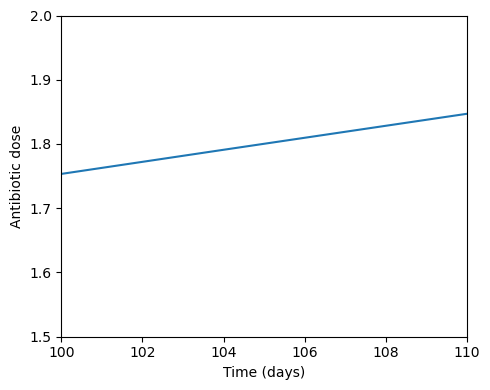

In [9]:
# Plot control signal
with torch.no_grad():
    u_values = u_net(t.unsqueeze(-1)).squeeze().cpu().numpy()

plt.figure(figsize=(5, 4))
plt.plot(t.numpy(), u_values)
plt.xlim(100, 110)
plt.ylim(1.5, 2.0)
plt.xlabel('Time (days)')
plt.ylabel('Antibiotic dose')
plt.tight_layout()
plt.show()

### Population Dynamics

Comparison of microbial populations with and without targeted treatment:

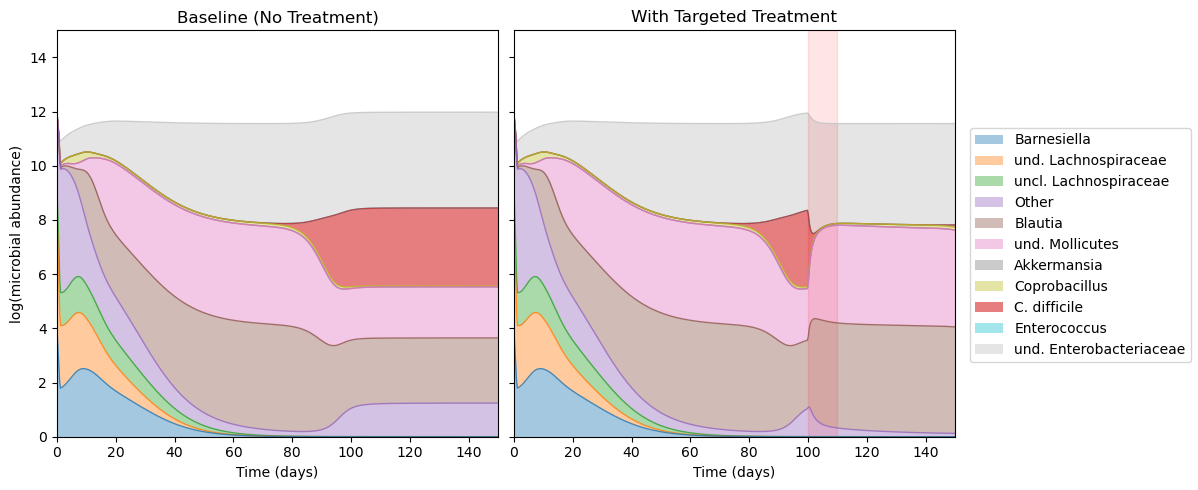

In [10]:
def plot_stacked_trajectories(traj1, traj2, t_end=150):
    """Visualize two trajectories side by side with stacked area plots."""
    
    def preprocess_trajectory(trajectory):
        y = trajectory.detach().numpy()
        y = np.maximum(y, 1e-20)  # Avoid log(0)
        y_total = y.sum(axis=1)
        y_log_total = 11 + np.log10(y_total)
        y_log_species = (y / y_total[:, None]) * y_log_total[:, None]
        y_stacked = np.cumsum(y_log_species, axis=1)
        return y_log_total, y_stacked

    y_log_total1, y_stacked1 = preprocess_trajectory(traj1)
    y_log_total2, y_stacked2 = preprocess_trajectory(traj2)
    t = np.linspace(0, t_end, len(traj1))

    # Color setup - highlight C. difficile in red
    tab10 = list(plt.cm.tab10.colors)
    tab10[3:-1] = tab10[4:]
    colors = [tab10[i % len(tab10)] for i in range(traj1.shape[1])]
    colors[-1] = 'silver'  # Last species in gray
    colors[8] = 'tab:red'  # C. difficile in red

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax_idx, (ax, y_stacked, y_log_total) in enumerate(zip(axes, [y_stacked1, y_stacked2], [y_log_total1, y_log_total2])):
        for i in range(traj1.shape[1] - 1, -1, -1):
            bottom = y_stacked[:, i - 1] if i > 0 else np.zeros_like(y_log_total)
            alpha = 0.6 if i == 8 else 0.4  # Highlight C. difficile
            ax.fill_between(t, bottom, y_stacked[:, i], 
                          color=colors[i], alpha=alpha, label=species[i], linewidth=0.0)
            ax.plot(t, y_stacked[:, i], color=colors[i], ls='-', lw=1.0, alpha=0.8)
            
        ax.set_xlim(0, t_end)
        ax.set_ylim(0, 15)
        ax.set_xlabel('Time (days)')
        if ax_idx == 0:
            ax.set_ylabel('log(microbial abundance)')
        
        # Add treatment window indicator
        if ax_idx == 1:
            ax.axvspan(100, 110, color='red', alpha=0.1)

    axes[0].set_title('Baseline (No Treatment)')
    axes[1].set_title('With Targeted Treatment')
    
    # Create a unified legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], loc='center right', ncol=1)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.show()

# Generate optimized trajectory
trajectory_optimized = odeint(model, IC5, t, method='dopri5')

# Plot comparison
plot_stacked_trajectories(trajectory_baseline, trajectory_optimized)

## Key Findings

1. **Targeted Treatment Effectiveness**: The optimized controller successfully suppresses *C. difficile* (red).

2. **Control Efficiency**: The neural controller learns to administer antibiotics in a way that reduces total usage.